In [3]:
from bci_aic3.data import BCIDataset, load_data

In [ ]:
from bci_aic3.paths import CONFIG_DIR, LABEL_MAPPING_PATH, RAW_DATA_DIR
from bci_aic3.util import read_json_to_dict

In [ ]:
from bci_aic3.models.eegnet import EEGNet

In [ ]:
label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)

In [7]:
train_mi, val_mi, test_mi = load_data(base_path=RAW_DATA_DIR, 
                                      task_type="MI",
                                      label_mapping=label_mapping) 

In [8]:
import mne

%matplotlib widget

In [107]:
SCALING_FACTOR = 1e-6
sampling_rate = 250
ch_names = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
ch_types = ['eeg'] * len(ch_names)

In [108]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')

In [109]:
index = 140
raw_trial = mne.io.RawArray(train_mi[index][0].data.T * SCALING_FACTOR, info)

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


In [110]:
train_mi[index][1].data

tensor(0)

In [111]:
train_mi[index][0].mean()

tensor(247869.7188)

In [112]:
# Set a standard montage
montage = mne.channels.make_standard_montage('standard_1020')
raw_trial.set_montage(montage, on_missing='ignore')

# Filter
raw_trial.filter(l_freq=5, h_freq=30, fir_design='firwin', verbose=False)
raw_trial.notch_filter(freqs=50, fir_design='firwin', verbose=False)

# Re-reference
raw_trial.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
raw_trial.apply_proj(verbose=False)

<RawArray | 8 x 2250 (9.0 s), ~156 KiB, data loaded>

In [ ]:
raw_trial.plot()

In [ ]:
# Plot the first 7 seconds of data for 8 channels
raw_trial.plot(duration=1, n_channels=8)
print()

TypeError: BaseRaw.plot() got an unexpected keyword argument 'average'

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


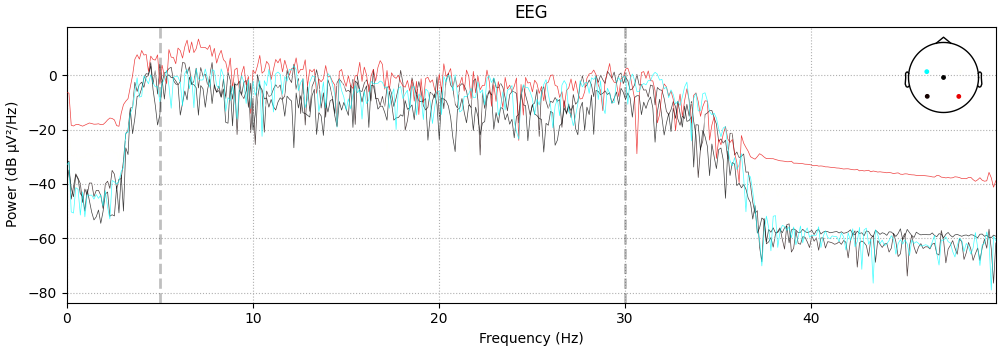

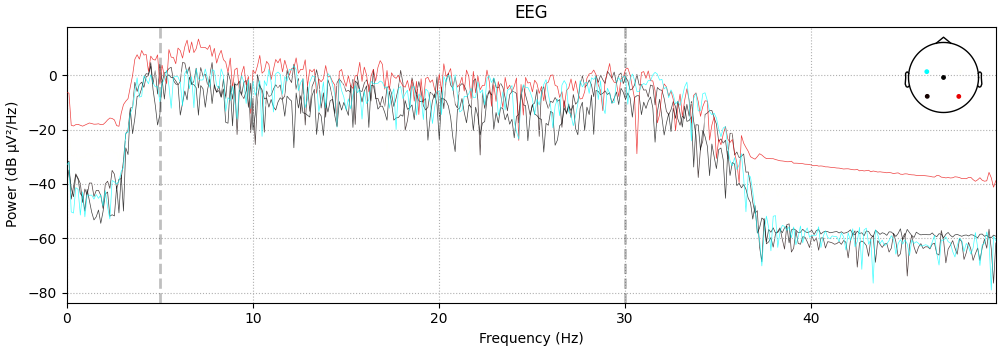

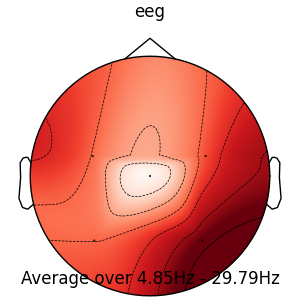

In [102]:
raw_trial.compute_psd(fmax=50, exclude=["OZ", "CZ", "FZ"]).plot()
print()

In [87]:
trial_data = raw_trial.get_data()
trial_data

array([[-1.30279623e-18,  1.96839425e-04,  3.35032095e-04, ...,
        -3.00982074e-04, -1.76595588e-04, -8.60453126e-19],
       [ 9.11650311e-18, -2.86899284e-04, -4.90841760e-04, ...,
         5.86418493e-04,  3.43127683e-04, -1.47625931e-17],
       [ 1.07816045e-18, -4.74847973e-04, -8.10240559e-04, ...,
         3.46729364e-04,  2.03188692e-04,  6.07399386e-18],
       ...,
       [ 3.46938739e-18,  2.18588527e-04,  3.73887009e-04, ...,
        -2.21610785e-04, -1.29320214e-04,  1.99578168e-17],
       [-4.98866010e-18,  1.85510770e-04,  3.16802898e-04, ...,
        -1.95884860e-04, -1.14505320e-04, -7.79807648e-18],
       [-1.06274114e-17,  3.11147745e-04,  5.31847094e-04, ...,
        -4.00067241e-04, -2.34325508e-04, -7.79733533e-18]],
      shape=(8, 2250))

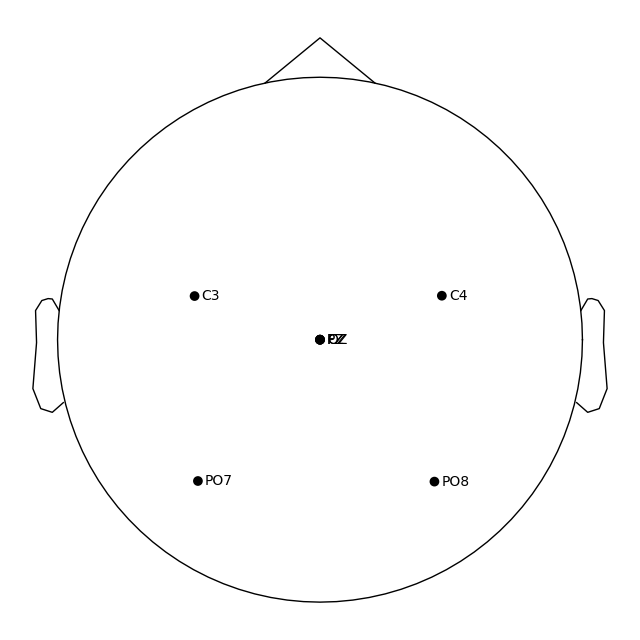

In [89]:
# Plot the sensor locations in 2D and 3D
raw_trial.plot_sensors(ch_type='eeg', show_names=True, block=True)
print()